
## <p style="text-align: center;">**Airline On Time Performance**</p>
### <p style="text-align: center;">**Univariate Analysis**</p>
### <p style="text-align: center;">**Matt Keeran**<br><br>9/24/19</p>


***
## **Table of Contents** <a id="toc"></a>
### 0. <a href="#schema">Schema</a>
### 1. <a href="#eda">Exploratory Data Analysis</a>
***

In [1]:
import sys
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
!ls

'Airline Arrivals Univariate.ipynb'   nohup.out    SF_Resturant_Scores
 Airline_On_Time_Performance	      README.md
 Bike-Sharing-Dataset		      schema.txt


In [5]:
!ls Airline_On_Time_Performance/

Airline_On_Time_Performance.csv  Airline_On_Time_Performance_ReadMe.csv


In [2]:
%time data = pd.read_csv('Airline_On_Time_Performance/Airline_On_Time_Performance.csv')
data.info()

CPU times: user 4.52 s, sys: 367 ms, total: 4.89 s
Wall time: 5.11 s
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638649 entries, 0 to 638648
Data columns (total 50 columns):
YEAR                      638649 non-null int64
MONTH                     638649 non-null int64
DAY_OF_MONTH              638649 non-null int64
DAY_OF_WEEK               638649 non-null int64
FL_DATE                   638649 non-null object
MKT_UNIQUE_CARRIER        638649 non-null object
MKT_CARRIER_AIRLINE_ID    638649 non-null int64
MKT_CARRIER_FL_NUM        638649 non-null int64
OP_UNIQUE_CARRIER         638649 non-null object
TAIL_NUM                  633964 non-null object
OP_CARRIER_FL_NUM         638649 non-null int64
ORIGIN_AIRPORT_ID         638649 non-null int64
ORIGIN_AIRPORT_SEQ_ID     638649 non-null int64
ORIGIN_CITY_MARKET_ID     638649 non-null int64
ORIGIN                    638649 non-null object
ORIGIN_CITY_NAME          638649 non-null object
ORIGIN_STATE_ABR          638649 non-null obje

In [3]:
data.drop('Unnamed: 49', axis=1, inplace=True)

In [4]:
schema = pd.read_csv('Airline_On_Time_Performance/Airline_On_Time_Performance_ReadMe.csv')
schema.head()

,SYS_FIELD_NAME,FIELD_DESC,Unnamed: 2
0,YEAR,Year,NaN
1,MONTH,Month,NaN
2,DAY_OF_MONTH,Day of Month,NaN
3,DAY_OF_WEEK,Day of Week,NaN
4,FL_DATE,Flight Date (yyyymmdd),NaN


In [7]:
list(schema.columns)

['SYS_FIELD_NAME', ' FIELD_DESC', 'Unnamed: 2']

In [5]:
schema.drop('Unnamed: 2', axis=1, inplace=True)
schema.columns = ['Field', 'Description']
schema.head()

,Field,Description
0,YEAR,Year
1,MONTH,Month
2,DAY_OF_MONTH,Day of Month
3,DAY_OF_WEEK,Day of Week
4,FL_DATE,Flight Date (yyyymmdd)


In [44]:
def scheme():
    f = open('schema.txt', 'w')
    f.write("SCHEMA:\n-----------------------------------------------------------------------------------------------------------------------------------------------------\n")
    print("SCHEMA:\n------------------------------------------------------------------------------------------------------------------------------------------------------------")
    for index, row in schema.iterrows():
        f.write('{}. {}:\t{}\t\t{:,} NON NULL VALUES\t\t{:,} TOTAL VALUES\t{:.2f} % NULL\n'.format(
            index,
            row['Field'], 
            str(type(data[row['Field']].iloc[0])), 
            (len(data[row['Field']]) - data[row['Field']].isnull().sum()),
            len(data[row['Field']]),
            ((data[row['Field']].isnull().sum()/len(data[row['Field']])))*100)
       )
        print('{}. {}:\t{}\t\t{:,} NON NULL VALUES\t\t{:,} TOTAL VALUES\t{:.2f} % NULL'.format(
            index,
            row['Field'], 
            str(type(data[row['Field']].iloc[0])), 
            (len(data[row['Field']]) - data[row['Field']].isnull().sum()),
            len(data[row['Field']]),
            ((data[row['Field']].isnull().sum()/len(data[row['Field']])))*100)
        )
        f.write(row['Description'] + '\n\n')
        print(row['Description'] + '\n')
        try:
            f.write('{}\t{}'.format(data[row['Field']].min(), data[row['Field']].max()))
            print('{}\t{}'.format(data[row['Field']].min(), data[row['Field']].max()))
        except Exception:
            f.write('{}'.format(list(data[row['Field']].value_counts().head(2).index)))
            print('{}'.format(list(data[row['Field']].value_counts().head(2).index)))
            
        f.write('\n------------------------------------------------------------------------------------------------------------------------------------------------------\n')
        print('\n---------------------------------------------------------------------------------------------------------------------------------------------------------------')
    f.close()

***
### **0. Schema** <a id="schema"></a>
##### <a href="#toc">Table of Contents</a>
***

In [45]:
scheme()

SCHEMA:
------------------------------------------------------------------------------------------------------------------------------------------------------------
0. YEAR:	<class 'numpy.int64'>		638,649 NON NULL VALUES		638,649 TOTAL VALUES	0.00 % NULL
Year

2019	2019

---------------------------------------------------------------------------------------------------------------------------------------------------------------
1. MONTH:	<class 'numpy.int64'>		638,649 NON NULL VALUES		638,649 TOTAL VALUES	0.00 % NULL
Month

1	1

---------------------------------------------------------------------------------------------------------------------------------------------------------------
2. DAY_OF_MONTH:	<class 'numpy.int64'>		638,649 NON NULL VALUES		638,649 TOTAL VALUES	0.00 % NULL
Day of Month

1	31

---------------------------------------------------------------------------------------------------------------------------------------------------------------
3. DAY_OF_WEEK:	<class 'num

***
### **1. Exploratory Data Analysis** <a id="eda"></a>
##### <a href="#schema">Schema</a>
##### <a href="#toc">Main Table of Contents</a>
###### 1. <a href="#date">Date</a>
###### 2. <a href="#mktcarrier">Unique Marketing Carrier Code</a>
###### 3. <a href="#mktcarrierid">Unique Marketing Carrier Id</a>
###### 4. <a href="#mktfl">Marketing Flight Number</a>
###### 5. <a href="#uqcarrier">Unique Carrier Code</a>
###### 6. <a href="#tail">Tail Number</a>
###### 7. <a href="#fl">Flight Number</a>
###### 8. <a href="#originid">Origin Airport ID</a>
###### 9. <a href="#originseq">Origin Sequence ID</a>
###### 10. <a href="#origincitymkt">City Market ID</a>
###### 11. <a href="#origin">Origin Airport</a>
###### 12. <a href="#origincity">Origin City</a>
###### 13. <a href="#originstate">Origin State Code</a>
###### 14. <a href="#destid">Destination ID</a>
###### 15. <a href="#destseq">Destination Sequence ID</a>
###### 16. <a href="#destcitymkt">Destination City Market ID</a>
###### 17. <a href="#dest">Destination Airport</a>
###### 18. <a href="#destcity">Destination City</a>
###### 19. <a href="#deststatecode">Destination State Code</a>
###### 20. <a href="#deststatefips">Destination State Fips</a>
###### 21. <a href="#destworld">Destination World Area Code</a>
###### 22. <a href="#deststate">Destination State</a>
###### 23. <a href="#crsdep">CRS Departure Time</a>
###### 24. <a href="#actualdep">Actual Departure Time</a>
###### 25. <a href="#depdelay">Departure Delay</a>
###### 26. <a href="#depdelaynew">Departure Delay New</a>
###### 27. <a href="#del15">15 min Delay +</a>
###### 28. <a href="#taxiout">Taxi Out Time</a>
###### 29. <a href="#wheelsoff">Wheels Off Time</a>
###### 30. <a href="#wheelson">Wheels On Time</a>
###### 31. <a href="#taxiin">Taxi In Time</a>
###### 32. <a href="#canceled">Cancelled Flight</a>
###### 33. <a href="#canceledreason">Cancellation Reason</a>
###### 34. <a href="#diverted">Diverted</a>
###### 35. <a href="#numfl">Number of Flights</a>
###### 36. <a href="#dist">Distance</a>
###### 37. <a href="#carrierdelay">Carrier Delay</a>
###### 38. <a href="#weatherdelay">Weather Delay</a>
###### 39. <a href="#nasdelay">National Air System Delay</a>
###### 40. <a href="#secdelay">Security Delay</a>
###### 41. <a href="#latedelay">Late Aircraft Delay</a>
###### 42. <a href="#numdiverted">Number of Diverted Airport Landings</a>
###### 43. <a href="#diff">Diff In Minutes</a>
###### 44. <a href="#diffdist">Diff In Distance</a>
###### 45. <a href="#dup">Duplicate Flag</a>
***

In [9]:
data.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,MKT_UNIQUE_CARRIER,MKT_CARRIER_AIRLINE_ID,MKT_CARRIER_FL_NUM,OP_UNIQUE_CARRIER,TAIL_NUM,...,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DIV_AIRPORT_LANDINGS,DIV_ARR_DELAY,DIV_DISTANCE,Unnamed: 49
0,2019,1,19,6,2019-01-19,DL,19790,5245,9E,N176PQ,...,596.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1,2019,1,20,7,2019-01-20,DL,19790,5245,9E,N309PQ,...,596.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2,2019,1,21,1,2019-01-21,DL,19790,5245,9E,N176PQ,...,596.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
3,2019,1,22,2,2019-01-22,DL,19790,5245,9E,N135EV,...,596.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
4,2019,1,23,3,2019-01-23,DL,19790,5245,9E,N294PQ,...,596.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN


In [10]:
data.describe()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_CARRIER_AIRLINE_ID,MKT_CARRIER_FL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,...,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DIV_AIRPORT_LANDINGS,DIV_ARR_DELAY,DIV_DISTANCE,Unnamed: 49
count,638649.0,638649.0,638649.000000,638649.000000,638649.000000,638649.000000,638649.000000,638649.000000,6.386490e+05,638649.000000,...,638649.000000,117144.000000,117144.000000,117144.000000,117144.000000,117144.000000,638649.000000,1061.000000,1450.000000,0.0
mean,2019.0,1.0,15.955094,3.836976,19822.089542,2700.769462,2700.871319,12690.345843,1.269038e+06,31776.883607,...,765.250902,20.088609,4.410785,18.384826,0.073422,25.880882,0.004459,305.625825,58.320000,NaN
std,0.0,0.0,8.989170,1.921977,261.399496,1861.613306,1861.933516,1520.775468,1.520773e+05,1316.122179,...,579.910495,65.596080,38.353695,41.352734,3.051185,53.007365,0.147790,281.088367,185.652297,NaN
min,2019.0,1.0,1.000000,1.000000,19393.000000,1.000000,1.000000,10135.000000,1.013505e+06,30070.000000,...,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000,NaN
25%,2019.0,1.0,8.000000,2.000000,19790.000000,1090.000000,1090.000000,11292.000000,1.129202e+06,30721.000000,...,337.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,133.000000,0.000000,NaN
50%,2019.0,1.0,16.000000,4.000000,19805.000000,2260.000000,2260.000000,12889.000000,1.288903e+06,31453.000000,...,604.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,189.000000,0.000000,NaN
75%,2019.0,1.0,24.000000,5.000000,19977.000000,4184.000000,4183.000000,14057.000000,1.405702e+06,32575.000000,...,1008.000000,16.000000,0.000000,21.000000,0.000000,30.000000,0.000000,332.000000,30.000000,NaN
max,2019.0,1.0,31.000000,7.000000,20436.000000,9401.000000,9401.000000,16218.000000,1.621802e+06,36101.000000,...,4983.000000,1638.000000,1416.000000,1447.000000,816.000000,1514.000000,9.000000,1557.000000,2586.000000,NaN


### Comparing metrics for both quantitative and categorical measures of delay

In [17]:
num_early = len(data[data['DEP_DELAY'] < 0])
num_ontime = len(data[data['DEP_DELAY'] <= 0])
num_delayed = len(data[data['DEP_DELAY'] > 0])
print('{:.2f} % of flights delayed'.format(num_delayed / len(data) * 100))
print('{:.2f} % of flights early or ontime'.format(num_ontime / len(data) * 100))
print('{:.2f} % of flights early'.format(num_early / len(data) * 100))

31.49 % of flights delayed
65.51 % of flights early or ontime
60.99 % of flights early


In [102]:
num_ontime = len(data[data['DEP_DEL15'] == 0])
num_delayed = len(data[data['DEP_DEL15'] == 1])
print('{:.2f} % of flights delayed'.format(num_delayed / len(data) * 100))
print('{:.2f} % of flights early or ontime'.format(num_ontime / len(data) * 100))

17.10 % of flights delayed
79.91 % of flights early or ontime


In [103]:
17.10+79.91

97.00999999999999

In [105]:
len(data[data['DEP_DELAY'].notnull()]) / len(data) * 100

97.00899868315773

In [106]:
len(data) - len(data[data['DEP_DELAY'].notnull()]) 

19102

### 3% of the data (19,102 rows) don't have info for delay time and delayed 15 min, implying they're missing the same rows

In [54]:
data_date['DEP_DELAY'].describe()

count    619547.000000
mean          9.995247
std          49.563587
min         -47.000000
25%          -6.000000
50%          -3.000000
75%           5.000000
max        1690.000000
Name: DEP_DELAY, dtype: float64

### Number & Percent of Flights Delayed More than 15 Minutes

In [55]:
len(data_date[data_date['DEP_DELAY'] > 15])

105620

In [19]:
len(data[data['DEP_DELAY'] > 15]) / len(data) * 100

16.53803575986183

In [25]:
len(data[data['DEP_DELAY'] < -15])

5675

### Only 5,675 flights left more than 15 minutes early in January

In [26]:
data.loc[data['CARRIER_DELAY'].notnull(), ['DEP_DELAY', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']].head()

,DEP_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
9,218.0,0.0,218.0,11.0,0.0,0.0
27,-6.0,0.0,0.0,19.0,0.0,0.0
30,-7.0,0.0,0.0,19.0,0.0,0.0
31,142.0,136.0,0.0,0.0,0.0,0.0
34,180.0,154.0,0.0,0.0,0.0,0.0


In [43]:
len(data[(data['CARRIER_DELAY'] == 0) & (data['WEATHER_DELAY'] == 0.0) & (data['NAS_DELAY'] == 0.0) & (data['SECURITY_DELAY'] == 0.0) & (data['LATE_AIRCRAFT_DELAY'] == 0.0)])

0

#### So there is no instance in which 

In [43]:
len(data[(data['CARRIER_DELAY'] == 0) & (data['WEATHER_DELAY'] == 0.0) & (data['NAS_DELAY'] == 0.0) & (data['SECURITY_DELAY'] == 0.0) & (data['LATE_AIRCRAFT_DELAY'] == 0.0)a])

0

## Goals of General Analysis
### * Determine what vairables exist, their distributions overtime and by airport 
### * Identify Potential Independent Vairables Related to Delays
### *How common are delays in general
### *Which Airports have the most delays and what are the most common types of delays (Both origin & destination airports?)
### *What are the most common types of delays
### How this data can be used <- calculate the probability you're flight will be delayed

## Airline & Airport Level Information
### Your flight is far more likely to be delayed if there is a flight departure time before you, at the same departure airport and airline and it was delayed
### same arrival airport  but flight in front (most recent of you at that airport and airline was delayed
### way to incorporate departure vs arrival delay components?
### Same Airline & Departure Airport Dummy var
### Same Airline & Arrival Airport Dummy var
### Same Airline & Departure Airport & deapture

In [ ]:
da

### List flights (unique tuples of origin & destination) for each ariline & their frequencies

## Airport Analysis
#### Analyzing the distribution of all cities isn't particualrly useful, of what use is a model which forecasts delays on a national level?
#### Would be much more useful to build forecast models for each airport as to 
#### 1. whether there will be a delay tomorrow 
#### 2. the estimated delay in minutes

# FOR EACH VAR PLOT OVER DATE & DAY OF WEEK

In [107]:
data_date = data.set_index('FL_DATE')
data = []
data_date.index

Index(['2019-01-19', '2019-01-20', '2019-01-21', '2019-01-22', '2019-01-23',
       '2019-01-24', '2019-01-25', '2019-01-26', '2019-01-27', '2019-01-28',
       ...
       '2019-01-30', '2019-01-30', '2019-01-30', '2019-01-30', '2019-01-30',
       '2019-01-30', '2019-01-30', '2019-01-30', '2019-01-30', '2019-01-30'],
      dtype='object', name='FL_DATE', length=638649)

In [60]:
""" 
    Display Size of Dataframes in Memory > 1MB 
    https://practicalpython.blogspot.com/2017/03/monitoring-memory-usage-in-jupyter.html
"""
def show_mem_usage():
    '''Displays memory usage from inspection
    of global variables in this notebook'''
    gl = sys._getframe(1).f_globals
    vars= {}
    for k,v in list(gl.items()):
        # for pandas dataframes
        if hasattr(v, 'memory_usage'):
            mem = v.memory_usage(deep=True)
            if not np.isscalar(mem):
                mem = mem.sum()
            vars.setdefault(id(v),[mem]).append(k)
        # work around for a bug
        elif isinstance(v,pd.Panel):
            v = v.values
        vars.setdefault(id(v),[sys.getsizeof(v)]).append(k)
    total = 0
    for k,(value,*names) in vars.items():
        if value>1e6:
            print(names,"%.3fMB"%(value/1e6))
        total += value
    print("%.3fMB"%(total/1e6))

In [108]:
show_mem_usage()

['_', '_', '_107', '_107'] 42.789MB
['data_date', 'data_date'] 691.463MB
['_46', '_46'] 42.789MB
['temp', 'temp'] 20.670MB
['delayed', 'delayed'] 118.156MB
['ontime', 'ontime'] 552.141MB
['_99', '_99'] 42.789MB
1510.938MB


In [25]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                          data: 656.7 MiB
                     data_date: 656.7 MiB
                           _13: 40.8 MiB
                        schema:  9.5 KiB
                           ___:  6.8 KiB
                           _16:  6.8 KiB
                            __:  5.4 KiB
                           _17:  5.4 KiB
                             _:  5.3 KiB
                           _18:  5.3 KiB


In [37]:
data_date[data_date.index == '2019-01-19'].head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_UNIQUE_CARRIER,MKT_CARRIER_AIRLINE_ID,MKT_CARRIER_FL_NUM,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CANCELLED,CANCELLATION_CODE,DIVERTED,DUP,FLIGHTS,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DIV_AIRPORT_LANDINGS,DIV_ARR_DELAY,DIV_DISTANCE
FL_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-19,2019,1,19,6,DL,19790,5245,9E,N176PQ,5245,13487,1348702,31650,MSP,"Minneapolis, MN",MN,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1556,1546.0,-10.0,0.0,0.0,14.0,1600.0,1827.0,5.0,0.0,NaN,0.0,N,1.0,596.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2019-01-19,2019,1,19,6,DL,19790,5246,9E,N927XJ,5246,13495,1349505,33495,MSY,"New Orleans, LA",LA,12953,1295304,31703,LGA,"New York, NY",NY,36,New York,22,601,603.0,2.0,2.0,0.0,15.0,618.0,927.0,4.0,0.0,NaN,0.0,N,1.0,1183.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2019-01-19,2019,1,19,6,DL,19790,5252,9E,N601LR,5252,12953,1295304,31703,LGA,"New York, NY",NY,10792,1079206,30792,BUF,"Buffalo, NY",NY,36,New York,22,1125,1116.0,-9.0,0.0,0.0,19.0,1135.0,1225.0,4.0,0.0,NaN,0.0,N,1.0,292.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2019-01-19,2019,1,19,6,DL,19790,5257,9E,N927EV,5257,12953,1295304,31703,LGA,"New York, NY",NY,13931,1393102,33667,ORF,"Norfolk, VA",VA,51,Virginia,38,1010,1007.0,-3.0,0.0,0.0,34.0,1041.0,1137.0,4.0,0.0,NaN,0.0,N,1.0,296.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2019-01-19,2019,1,19,6,DL,19790,5260,9E,N303PQ,5260,15096,1509602,35096,SYR,"Syracuse, NY",NY,11433,1143302,31295,DTW,"Detroit, MI",MI,26,Michigan,43,1700,2025.0,205.0,205.0,1.0,52.0,2117.0,2230.0,9.0,0.0,NaN,0.0,N,1.0,374.0,205.0,0.0,20.0,0.0,0.0,0,NaN,NaN


In [43]:
data_date.loc[data_date['CARRIER_DELAY'].notnull(), ['CARRIER_DELAY','WEATHER_DELAY', 'NAS_DELAY','SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'DIV_ARR_DELAY' ]].head()

,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DIV_ARR_DELAY
FL_DATE,,,,,,
2019-01-28,0.0,218.0,11.0,0.0,0.0,NaN
2019-01-18,0.0,0.0,19.0,0.0,0.0,NaN
2019-01-21,0.0,0.0,19.0,0.0,0.0,NaN
2019-01-22,136.0,0.0,0.0,0.0,0.0,NaN
2019-01-25,154.0,0.0,0.0,0.0,0.0,NaN


In [49]:
len(data_date[data_date['CARRIER_DELAY'].notnull()])

117144

### Clearly CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY are related as they have the exact same number of null values

### What is the relationship between the presence of individual delay components and delay in minutes?

### Distribution of Departure Delay in Minutes when Carrier Dealy is not Null

In [97]:
carrierdelay = len(data_date[data_date['CARRIER_DELAY'].notnull()])
nocarrierdelay = len(data_date) - carrierdelay
print('{:,}\n{:,}'.format(carrierdelay,nocarrierdelay))

117,144
521,505


Text(0.5, 1.0, 'Delay in Minutes When Carrier Delay is not Null')

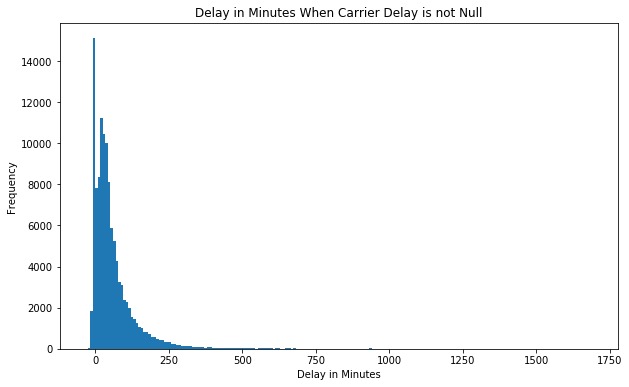

In [62]:
ax = data_date[data_date['CARRIER_DELAY'].notnull()]['DEP_DELAY'].plot.hist(figsize=(10,6), bins=200)
ax.set_xlabel("Delay in Minutes")
ax.set_title("Delay in Minutes When Carrier Delay is not Null")

Text(0.5, 1.0, 'Delay in Minutes')

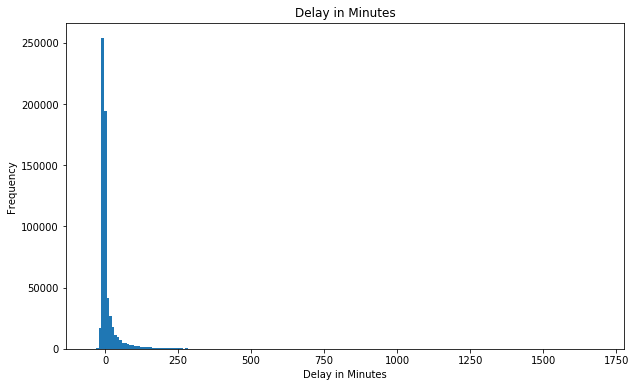

In [54]:
ax = data_date['DEP_DELAY'].plot.hist(figsize=(10,6), bins=200)
ax.set_xlabel("Delay in Minutes")
ax.set_title("Delay in Minutes")

### The distribution of delay in minutes appears to be significantly higher than when component delay data is not present, though there are ~5 times more observations of when delay component info is not available

In [57]:
len(data_date[data_date['DEP_DELAY'] >= 15])

109181

In [55]:
data_date['DEP_DEL15'].value_counts()

0.0    510366
1.0    109181
Name: DEP_DEL15, dtype: int64

### Distribution of Departure Times when there is a delay > 15 min

In [ ]:
for col in list(data_date.columns):
    
        fig, (ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(10,6))

        ax1.set_title('Delay > 15 Min')
        freq = delayed[col].value_counts().sort_index()
        ax1.bar(list(freq.index),freq)
        ax1.set_ylabel('Frequency')

        ax2.set_title('No Delay and < 15 Min')
        freq = no_heart_disease[col].value_counts().sort_index()
        ax2.bar(list(freq.index),freq)

        fig.suptitle('' + col)
        plt.show()

In [65]:
data_date[data_date.index == dates[0]].head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_UNIQUE_CARRIER,MKT_CARRIER_AIRLINE_ID,MKT_CARRIER_FL_NUM,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CANCELLED,CANCELLATION_CODE,DIVERTED,DUP,FLIGHTS,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DIV_AIRPORT_LANDINGS,DIV_ARR_DELAY,DIV_DISTANCE
FL_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-08,2019,1,8,2,DL,19790,5246,9E,N304PQ,5246,13495,1349505,33495,MSY,"New Orleans, LA",LA,12953,1295304,31703,LGA,"New York, NY",NY,36,New York,22,601,551.0,-10.0,0.0,0.0,13.0,604.0,929.0,7.0,0.0,NaN,0.0,N,1.0,1183.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2019-01-08,2019,1,8,2,DL,19790,5247,9E,N8837B,5247,14100,1410005,34100,PHL,"Philadelphia, PA",PA,14492,1449202,34492,RDU,"Raleigh/Durham, NC",NC,37,North Carolina,36,832,1048.0,136.0,136.0,1.0,22.0,1110.0,1210.0,5.0,0.0,NaN,0.0,N,1.0,337.0,0.0,0.0,0.0,0.0,112.0,0,NaN,NaN
2019-01-08,2019,1,8,2,DL,19790,5247,9E,N8837B,5247,14492,1449202,34492,RDU,"Raleigh/Durham, NC",NC,14100,1410005,34100,PHL,"Philadelphia, PA",PA,42,Pennsylvania,23,630,848.0,138.0,138.0,1.0,35.0,923.0,1019.0,9.0,0.0,NaN,0.0,N,1.0,337.0,138.0,0.0,3.0,0.0,0.0,0,NaN,NaN
2019-01-08,2019,1,8,2,DL,19790,5248,9E,N131EV,5248,10792,1079206,30792,BUF,"Buffalo, NY",NY,12953,1295304,31703,LGA,"New York, NY",NY,36,New York,22,540,559.0,19.0,19.0,1.0,14.0,613.0,703.0,10.0,0.0,NaN,0.0,N,1.0,292.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2019-01-08,2019,1,8,2,DL,19790,5249,9E,N197PQ,5249,13487,1348702,31650,MSP,"Minneapolis, MN",MN,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,2020,2016.0,-4.0,0.0,0.0,25.0,2041.0,2254.0,6.0,0.0,NaN,0.0,N,1.0,596.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [73]:
dates = list(set(list(data_date.index)))
len(dates)

31

In [90]:
#data_date.drop(['YEAR', 'MONTH', 'DAY_OF_MONTH'], axis=1, inplace=True)
data_date.drop(['DAY_OF_WEEK'], axis=1, inplace=True)

### Plotting frequency of flights by carrier not so useful due to major airlines having so many more flights, better to use % delayed & ontime

In [92]:
dates = list(set(list(data_date.index)))
dates.sort()
for col in list(data_date.columns):
    if(col != 'DEP_DEL15'):
        for date in dates:
            temp = data_date[data_date.index == date]
            delayed = temp[temp['DEP_DEL15'] == 1]
            ontime = temp[temp['DEP_DEL15'] == 0]
            print("")
            fig, (ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(10,6))

            ax1.set_title('Delay > 15 Min')
            ax1.set_ylabel('Frequency')

            ax2.set_title('No Delay and < 15 Min')
            if len(temp[col].value_counts()) < 50:
                freq = delayed[col].value_counts().sort_index()
                ax1.bar(list(freq.index),freq)

                freq = ontime[col].value_counts().sort_index()
                ax2.bar(list(freq.index),freq)

                #delayed[col].value_counts().plot.bar(figsize=(10,6))
                #ontime[col].value_counts().plot.bar(figsize=(10,6))
            else:
                freq = delayed[col].value_counts().sort_index()
                ax1.hist(list(freq.index),freq)

                freq = ontime[col].value_counts().sort_index()
                ax2.hist(list(freq.index),freq)
                #delayed[col].value_counts().plot.hist(figsize=(10,6))
                #ontime[col].value_counts().plot.hist(figsize=(10,6))
                
            fig.suptitle('{}:    {}'.format(col, date))
            plt.show()
        print("----------------------------------------------------------------------------------------------------------------------------------------")


In [18]:
data_date[:5]

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_UNIQUE_CARRIER,MKT_CARRIER_AIRLINE_ID,MKT_CARRIER_FL_NUM,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CANCELLED,CANCELLATION_CODE,DIVERTED,DUP,FLIGHTS,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DIV_AIRPORT_LANDINGS,DIV_ARR_DELAY,DIV_DISTANCE
FL_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-19,2019,1,19,6,DL,19790,5245,9E,N176PQ,5245,13487,1348702,31650,MSP,"Minneapolis, MN",MN,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1556,1546.0,-10.0,0.0,0.0,14.0,1600.0,1827.0,5.0,0.0,NaN,0.0,N,1.0,596.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2019-01-20,2019,1,20,7,DL,19790,5245,9E,N309PQ,5245,13487,1348702,31650,MSP,"Minneapolis, MN",MN,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1556,1552.0,-4.0,0.0,0.0,12.0,1604.0,1820.0,5.0,0.0,NaN,0.0,N,1.0,596.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2019-01-21,2019,1,21,1,DL,19790,5245,9E,N176PQ,5245,13487,1348702,31650,MSP,"Minneapolis, MN",MN,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1556,1547.0,-9.0,0.0,0.0,36.0,1623.0,1839.0,6.0,0.0,NaN,0.0,N,1.0,596.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2019-01-22,2019,1,22,2,DL,19790,5245,9E,N135EV,5245,13487,1348702,31650,MSP,"Minneapolis, MN",MN,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1556,1552.0,-4.0,0.0,0.0,21.0,1613.0,1834.0,5.0,0.0,NaN,0.0,N,1.0,596.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2019-01-23,2019,1,23,3,DL,19790,5245,9E,N294PQ,5245,13487,1348702,31650,MSP,"Minneapolis, MN",MN,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1556,1550.0,-6.0,0.0,0.0,22.0,1612.0,1844.0,6.0,0.0,NaN,0.0,N,1.0,596.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [17]:
data.iloc[:5]

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,MKT_UNIQUE_CARRIER,MKT_CARRIER_AIRLINE_ID,MKT_CARRIER_FL_NUM,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CANCELLED,CANCELLATION_CODE,DIVERTED,DUP,FLIGHTS,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DIV_AIRPORT_LANDINGS,DIV_ARR_DELAY,DIV_DISTANCE
0,2019,1,19,6,2019-01-19,DL,19790,5245,9E,N176PQ,5245,13487,1348702,31650,MSP,"Minneapolis, MN",MN,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1556,1546.0,-10.0,0.0,0.0,14.0,1600.0,1827.0,5.0,0.0,NaN,0.0,N,1.0,596.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,2019,1,20,7,2019-01-20,DL,19790,5245,9E,N309PQ,5245,13487,1348702,31650,MSP,"Minneapolis, MN",MN,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1556,1552.0,-4.0,0.0,0.0,12.0,1604.0,1820.0,5.0,0.0,NaN,0.0,N,1.0,596.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2,2019,1,21,1,2019-01-21,DL,19790,5245,9E,N176PQ,5245,13487,1348702,31650,MSP,"Minneapolis, MN",MN,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1556,1547.0,-9.0,0.0,0.0,36.0,1623.0,1839.0,6.0,0.0,NaN,0.0,N,1.0,596.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
3,2019,1,22,2,2019-01-22,DL,19790,5245,9E,N135EV,5245,13487,1348702,31650,MSP,"Minneapolis, MN",MN,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1556,1552.0,-4.0,0.0,0.0,21.0,1613.0,1834.0,5.0,0.0,NaN,0.0,N,1.0,596.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
4,2019,1,23,3,2019-01-23,DL,19790,5245,9E,N294PQ,5245,13487,1348702,31650,MSP,"Minneapolis, MN",MN,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1556,1550.0,-6.0,0.0,0.0,22.0,1612.0,1844.0,6.0,0.0,NaN,0.0,N,1.0,596.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [100]:
delayed = data_date[data_date['DEP_DEL15'] == 1]
ontime = data_date[data_date['DEP_DEL15'] == 0]
data_date = []

---
### **Date** <a id="date"></a>
##### <a href="#eda">EDA</a>
---

In [24]:
data['FL_DATE'].min()

'2019-01-01'

In [25]:
data['FL_DATE'].max()

'2019-01-31'

In [145]:
data['FL_DATE'].value_counts()

2019-01-02    22311
2019-01-11    21934
2019-01-25    21889
2019-01-18    21858
2019-01-07    21851
2019-01-10    21823
2019-01-31    21802
2019-01-24    21801
2019-01-17    21800
2019-01-14    21781
2019-01-28    21772
2019-01-04    21439
2019-01-03    21384
2019-01-21    21312
2019-01-06    21284
2019-01-09    21020
2019-01-30    20889
2019-01-23    20886
2019-01-16    20881
2019-01-08    20566
2019-01-29    20411
2019-01-22    20407
2019-01-15    20402
2019-01-27    20306
2019-01-13    20300
2019-01-01    19683
2019-01-05    18533
2019-01-20    18454
2019-01-12    16773
2019-01-26    16727
2019-01-19    16370
Name: FL_DATE, dtype: int64

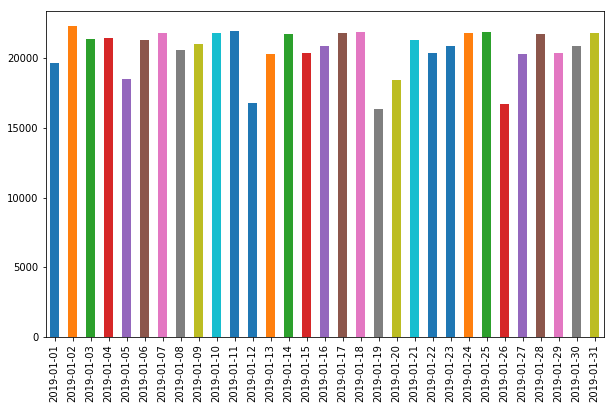

In [152]:
ax = data['FL_DATE'].value_counts().sort_index().plot.bar(figsize=(10,6))
ax.set_title('# of Flights Per Day')

### So this is a dataset from January of this year. Also there are obvious cyclical patterns.

In [ ]:
for date in list(delayed.index):
    

In [80]:
data['DAY_OF_WEEK'].value_counts()

4    108610
3    105987
2    101469
5     87120
1     86716
7     80344
6     68403
Name: DAY_OF_WEEK, dtype: int64

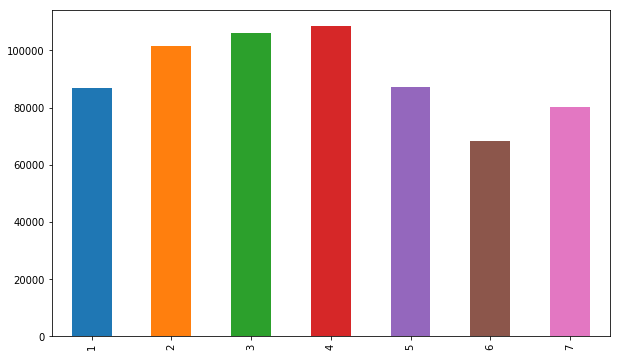

In [153]:
ax = data['DAY_OF_WEEK'].value_counts().sort_index().plot.bar(figsize=(10,6))
ax.set_title('# Flights By Day Of Week')

Text(0.5, 1.0, 'Distribution of Day of Week for On-Time Flights')

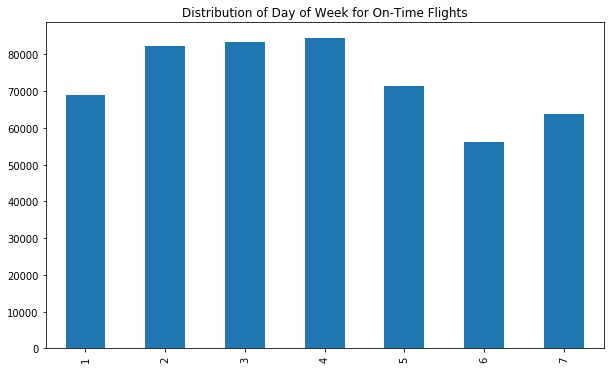

In [111]:
ax = ontime['DAY_OF_WEEK'].value_counts().sort_index().plot.bar(figsize=(10,6))
ax.set_title('Distribution of Day of Week for On-Time Flights')

Text(0.5, 1.0, 'Distribution of Day of Week for Flights w/ > 15 Min Delay')

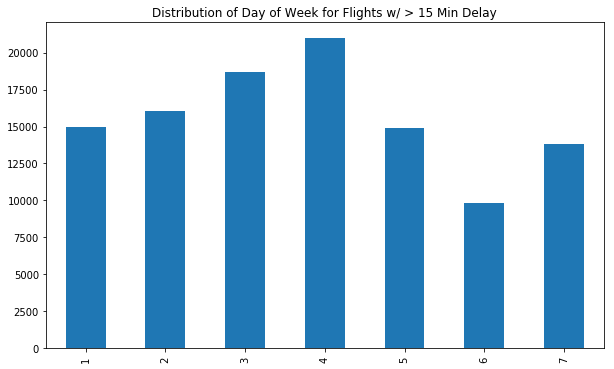

In [112]:
ax = delayed['DAY_OF_WEEK'].value_counts().sort_index().plot.bar(figsize=(10,6))
ax.set_title('Distribution of Day of Week for Flights w/ > 15 Min Delay')

### Both Ontime and Delayed flights show roughly the same distribution/pattern according to Day of the Week

---
### **Unique Marketing Carrier Code** <a id="mktcarrier"></a>
##### <a href="#eda">EDA</a>
---

### Number of Airline Marketing Codes

In [163]:
len(data['MKT_UNIQUE_CARRIER'].value_counts())

10

### Number of records of each Airline Marketing Code 

In [138]:
data['MKT_UNIQUE_CARRIER'].value_counts()

AA    168763
DL    135756
UA    123804
WN    111312
AS     35399
B6     24443
NK     15222
F9      9647
HA      7540
G4      6763
Name: MKT_UNIQUE_CARRIER, dtype: int64

In [ ]:
data['MKT_UNIQUE_CARRvIER'].value_counts()[0]/len(data)*100

### So AA accounts for ~25% of all the data out of the 10 airlines present

Text(0.5, 1.0, 'MKT_UNIQUE_CARRIER')

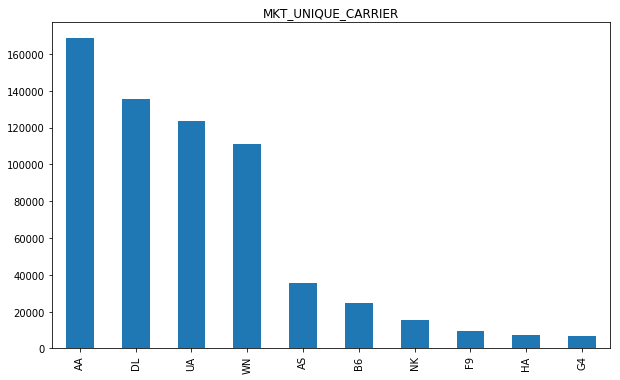

In [98]:
ax = data['MKT_UNIQUE_CARRIER'].value_counts().plot.bar(figsize=(10,6))
ax.set_title('MKT_UNIQUE_CARRIER')

### % Delayed according to Airline

In [116]:
ontime_airline_freqs = ontime['MKT_UNIQUE_CARRIER'].value_counts()
delayed_airline_freqs = delayed['MKT_UNIQUE_CARRIER'].value_counts()
print(len(ontime_airline_freqs), len(delayed_airline_freqs))

10 10


In [133]:
print("Airline\tTotal\tOntime\tDelayed\t% Delayed")
for airline in list(ontime_airline_freqs.index):
    total = ontime_airline_freqs[ontime_airline_freqs.index == airline][0] + delayed_airline_freqs[delayed_airline_freqs.index == airline][0]
    print("{}:\t{}\t{}\t{}\t{:.2f}\n".format(
        airline,
        total,
        ontime_airline_freqs[ontime_airline_freqs.index == airline][0],
        delayed_airline_freqs[delayed_airline_freqs.index == airline][0],
        (delayed_airline_freqs[delayed_airline_freqs.index == airline][0] / total * 100)
    ))

Airline	Total	Ontime	Delayed	% Delayed
AA:	163103	135679	27424	16.81

DL:	134308	113194	21114	15.72

UA:	117790	93234	24556	20.85

WN:	107394	88887	18507	17.23

AS:	34711	30101	4610	13.28

B6:	23474	17112	6362	27.10

NK:	15029	12858	2171	14.45

F9:	9507	7169	2338	24.59

HA:	7515	6857	658	8.76

G4:	6716	5275	1441	21.46



### So JetBlue had the highest % of its flights delayed > 15 min in Jan at 27%, with Frontier Airlines in second with 24 %.
### 4/10 had 20% or more of their flights delayed
### Hawaiian Airlines had the least with only ~9% of flights delayed, but they also one of the smallest airlines present (# flights)

---
### List of Top Origin & Destination Airports according to Airline

In [138]:
for airline in list(ontime_airline_freqs.index):
    print(airline)
    temp = data_date[data_date['MKT_UNIQUE_CARRIER'] == airline]['ORIGIN'].value_counts()
    temp2 = data_date[data_date['MKT_UNIQUE_CARRIER'] == airline]['DEST'].value_counts()
    df = pd.DataFrame([temp.head(10),temp2.head(10)])
    print("{} Number of Origin Airports".format(len(temp)))
    print("{} Number of Destination Airports".format(len(temp2)))
    print(df)
    print()

AA
234 Number of Origin Airports
234 Number of Destination Airports
          DFW    CLT    ORD   PHL   PHX   DCA   MIA   LAX   LGA   BOS
ORIGIN  20371  18822  12621  9054  7437  7015  6596  5416  4284  2330
DEST    20387  18828  12624  9056  7436  7022  6591  5411  4291  2331

DL
220 Number of Origin Airports
220 Number of Destination Airports
          ATL    DTW   MSP   SLC   LGA   JFK   LAX   SEA   BOS   RDU
ORIGIN  24124  10347  9452  7074  6474  4598  3888  3504  2630  1815
DEST    24122  10342  9448  7091  6475  4599  3887  3505  2637  1817

UA
229 Number of Origin Airports
228 Number of Destination Airports
          ORD    IAH    DEN   EWR   SFO   IAD   LAX   CLE   LAS   LGA
ORIGIN  15556  12347  12023  9145  7419  5811  3950  1274  1136  1098
DEST    15560  12335  12026  9144  7424  5808  3948  1276  1140  1100

WN
85 Number of Origin Airports
85 Number of Destination Airports
         MDW   LAS   DAL   DEN   BWI   PHX   HOU   MCO   LAX   ATL
ORIGIN  6038  5967  5760  5500  5

### List of most popular flights for each airline

In [150]:
print("Most Popular Flights By Airline\n")
for airline in list(ontime_airline_freqs.index):
    print(airline)
    flights = []
    temp = data_date[data_date['MKT_UNIQUE_CARRIER'] == airline]
    for index, row in temp.iterrows():
        flights.append('{} -> {}'.format(row['ORIGIN'],row['DEST']))
    
    df = pd.DataFrame(flights)
    fl_freqs = df[0].value_counts()
    print("{} Flights".format(len(fl_freqs)))
    print(fl_freqs.head(10))
    print()

Most Popular Flights By Airline

AA
1581 Flights
LAX -> DFW    397
DFW -> LAX    395
ORD -> LGA    379
LGA -> ORD    379
MIA -> LGA    368
LGA -> MIA    368
DCA -> BOS    364
BOS -> DCA    363
ORD -> DFW    362
DFW -> PHX    358
Name: 0, dtype: int64

DL
1417 Flights
MCO -> ATL    499
ATL -> MCO    497
LGA -> ATL    437
ATL -> LGA    437
ATL -> FLL    411
FLL -> ATL    411
ATL -> TPA    373
TPA -> ATL    373
LGA -> BOS    363
BOS -> LGA    363
Name: 0, dtype: int64

UA
1365 Flights
LGA -> ORD    434
ORD -> LGA    434
LAX -> SFO    430
SFO -> LAX    426
ORD -> DCA    390
DCA -> ORD    389
EWR -> SFO    324
SFO -> EWR    322
IAH -> DEN    313
DEN -> IAH    313
Name: 0, dtype: int64

WN
1378 Flights
HOU -> DAL    575
DAL -> HOU    574
SJC -> SAN    419
SAN -> SJC    418
SAN -> SMF    401
SMF -> SAN    401
OAK -> LAX    377
LAX -> OAK    377
BUR -> OAK    353
OAK -> BUR    353
Name: 0, dtype: int64

AS
494 Flights
PDX -> SEA    713
SEA -> PDX    710
SEA -> GEG    466
SEA -> SFO    465
GEG 

---
### **Origin Airport** <a id="origin"></a>
##### <a href="#eda">EDA</a>

### Number of Origin Airports

In [129]:
len(data_date['ORIGIN'].value_counts())

360

### Top Airports of Origin

In [130]:
data_date['ORIGIN'].value_counts().head(15)

ATL    31207
ORD    31064
DFW    23132
DEN    21540
CLT    20769
LAX    20376
PHX    14995
SEA    14937
IAH    14643
SFO    14242
LGA    13872
DTW    13686
LAS    13546
EWR    12440
MSP    12316
Name: ORIGIN, dtype: int64

### Atlanta is the most popular origin, with Chicago a close second

---
### **Destination Airport** <a id="dest"></a>
##### <a href="#eda">EDA</a>

### Number of Destination Airports

In [131]:
len(data_date['DEST'].value_counts())

360

### Top Destination Airports

In [132]:
data_date['DEST'].value_counts().head(15)

ATL    31203
ORD    31067
DFW    23147
DEN    21531
CLT    20775
LAX    20368
PHX    14998
SEA    14939
IAH    14631
SFO    14253
LGA    13882
DTW    13676
LAS    13553
EWR    12434
MSP    12320
Name: DEST, dtype: int64

---
### **Airline ID**

In [164]:
len(data['MKT_CARRIER_AIRLINE_ID'].value_counts())

10

In [139]:
data['MKT_CARRIER_AIRLINE_ID'].value_counts()

19805    168763
19790    135756
19977    123804
19393    111312
19930     35399
20409     24443
20416     15222
20436      9647
19690      7540
20368      6763
Name: MKT_CARRIER_AIRLINE_ID, dtype: int64

#### So MKT_UNIQUE_CARRIER and MKT_CARRIER_AIRLINE_ID are alternate encodings for airline brand

---
### **Marketing Flight Number**

In [141]:
len(data['MKT_CARRIER_FL_NUM'].value_counts())

6873

In [142]:
data['MKT_CARRIER_FL_NUM'].value_counts().head()

403     310
2116    294
761     291
2011    288
465     287
Name: MKT_CARRIER_FL_NUM, dtype: int64

#### So Flight 403 has the most observations, what carrier(s) are have records with flight 403?

In [155]:
data[data['MKT_CARRIER_FL_NUM'] == 403]['MKT_UNIQUE_CARRIER'].value_counts()

WN    120
NK     62
AA     52
UA     31
B6     31
F9     14
Name: MKT_UNIQUE_CARRIER, dtype: int64

#### So Flight 403, and flight numbers in general are not unique to airline.

In [143]:
data['MKT_CARRIER_FL_NUM'].value_counts().tail()

6356    1
6361    1
6360    1
6365    1
6395    1
Name: MKT_CARRIER_FL_NUM, dtype: int64

---
### **Unique Carrier Code**

In [162]:
len(data['OP_UNIQUE_CARRIER'].value_counts())

26

In [161]:
data['OP_UNIQUE_CARRIER'].value_counts()

WN    111312
AA     77017
DL     73836
OO     65115
UA     46915
YX     25773
MQ     25696
B6     24443
OH     23170
AS     20744
9E     20210
YV     18331
NK     15222
EV     13017
QX     10054
F9      9647
PT      9030
ZW      8726
CP      8194
G7      7221
HA      6798
G4      6763
AX      6254
C5      4207
EM       742
KS       212
Name: OP_UNIQUE_CARRIER, dtype: int64

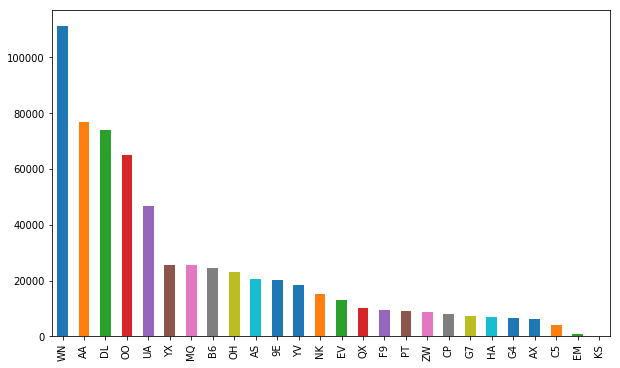

In [4]:
data['OP_UNIQUE_CARRIER'].value_counts().plot.bar(figsize=(10,6))

---
### **Tail Number**

In [165]:
len(data['TAIL_NUM'].value_counts())

5825

In [167]:
data['TAIL_NUM'].value_counts().head()

N488HA    361
N481HA    348
N483HA    346
N489HA    344
N493HA    328
Name: TAIL_NUM, dtype: int64

In [7]:
data[data['TAIL_NUM'] == 'N488HA']['OP_UNIQUE_CARRIER'].value_counts()

HA    361
Name: OP_UNIQUE_CARRIER, dtype: int64

In [8]:
data[data['TAIL_NUM'] == 'N481HA']['OP_UNIQUE_CARRIER'].value_counts()

HA    348
Name: OP_UNIQUE_CARRIER, dtype: int64

In [9]:
data[data['TAIL_NUM'] == 'N483HA']['OP_UNIQUE_CARRIER'].value_counts()

HA    346
Name: OP_UNIQUE_CARRIER, dtype: int64

In [10]:
data[data['TAIL_NUM'] == 'N493HA']['OP_UNIQUE_CARRIER'].value_counts()

HA    328
Name: OP_UNIQUE_CARRIER, dtype: int64

#### So the most common tail numbers all come from HA airline. Also, in general it appears that tail numbers are unique to unique carrier codes.

In [5]:
data['TAIL_NUM'].value_counts().tail()

N665UA    1
N706DN    1
N225AG    1
N2737U    1
N2644U    1
Name: TAIL_NUM, dtype: int64

---
### **Carrier Flight Number**

In [11]:
len(data['OP_CARRIER_FL_NUM'].value_counts())

6880

In [72]:
data['OP_CARRIER_FL_NUM'].value_counts().head()

403     310
2116    294
761     291
2011    288
465     287
Name: OP_CARRIER_FL_NUM, dtype: int64

In [73]:
data[data['OP_CARRIER_FL_NUM'] == 403]['OP_UNIQUE_CARRIER'].value_counts()

WN    120
NK     62
AA     52
B6     31
UA     31
F9     14
Name: OP_UNIQUE_CARRIER, dtype: int64

In [14]:
cols = list(data.columns)